# Monocular Visual Odometry - Relative Pose Estimation

This notebook demonstrates a high-accuracy monocular visual odometry system for estimating relative pose (rotation and translation direction) between two images.

## Features
- **SuperPoint + LightGlue** for robust feature matching
- **Essential matrix estimation** with MAGSAC++ robust estimation
- **Fisheye distortion support** for wide-angle cameras
- **Multiple dataset support**: UZH-FPV, KITTI, TUM, ICL-NUIM

## Performance Summary
On the UZH-FPV drone racing dataset:
- **Rotation error**: 0.41° mean
- **Translation direction error**: 2.83° mean  
- **Combined accuracy** (rot<5° AND dir<5°): **100%**

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as Rot
import cv2

# Import our pose estimator
from estimate_pose import PoseEstimator

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## 2. Load UZH-FPV Dataset

The UZH-FPV dataset contains drone racing sequences captured with a DAVIS 346 event camera (346x260 grayscale images).

Dataset: [UZH-FPV Drone Racing Dataset](https://fpv.ifi.uzh.ch/)

In [2]:
# Dataset configuration
DATA_DIR = Path('test_images')

# DAVIS 346 camera intrinsics (from official calibration)
K = np.array([[172.98992850734132, 0, 163.33639726024606],
              [0, 172.98303181090185, 134.99537889030861],
              [0, 0, 1]], dtype=np.float64)

# Fisheye distortion coefficients
DIST_COEFFS = np.array([-0.027576733308582076, -0.006593578674675004,
                        0.0008566938165177085, -0.00030899587045247486])

print("Camera Intrinsics (K):")
print(f"  fx = {K[0,0]:.2f}, fy = {K[1,1]:.2f}")
print(f"  cx = {K[0,2]:.2f}, cy = {K[1,2]:.2f}")
print(f"\nDistortion: {DIST_COEFFS}")

Camera Intrinsics (K):
  fx = 172.99, fy = 172.98
  cx = 163.34, cy = 135.00

Distortion: [-0.02757673 -0.00659358  0.00085669 -0.000309  ]


In [3]:
def load_uzh_dataset(data_dir):
    """Load UZH-FPV dataset with ground truth."""
    # Load ground truth poses
    gt_data = []
    with open(data_dir / 'groundtruth.txt', 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            ts = float(parts[0])
            t = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
            q = np.array([float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])])
            gt_data.append({'ts': ts, 't': t, 'R': Rot.from_quat(q).as_matrix()})
    
    gt_times = np.array([g['ts'] for g in gt_data])
    gt_start, gt_end = gt_times[0], gt_times[-1]
    
    # Load image list
    images = []
    with open(data_dir / 'images.txt', 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            ts = float(parts[1])
            img_path = data_dir / parts[2]
            # Only include images within GT time range
            if gt_start <= ts <= gt_end:
                images.append((ts, str(img_path)))
    
    # Interpolate GT for each image
    image_paths = []
    poses = []
    
    for ts, img_path in images:
        idx = np.searchsorted(gt_times, ts)
        if idx == 0 or idx >= len(gt_times): continue
        
        t0, t1 = gt_times[idx-1], gt_times[idx]
        alpha = (ts - t0) / (t1 - t0)
        
        t_interp = (1-alpha) * gt_data[idx-1]['t'] + alpha * gt_data[idx]['t']
        R0, R1 = gt_data[idx-1]['R'], gt_data[idx]['R']
        r0, r1 = Rot.from_matrix(R0), Rot.from_matrix(R1)
        R_interp = Rot.from_rotvec((1-alpha) * r0.as_rotvec() + alpha * r1.as_rotvec()).as_matrix()
        
        if Path(img_path).exists():
            image_paths.append(img_path)
            poses.append({'t': t_interp, 'R': R_interp})
    
    return image_paths, poses

# Load dataset
image_paths, poses = load_uzh_dataset(DATA_DIR)
print(f"Loaded {len(image_paths)} images with ground truth poses")

Loaded 627 images with ground truth poses


## 3. Visualize Sample Images

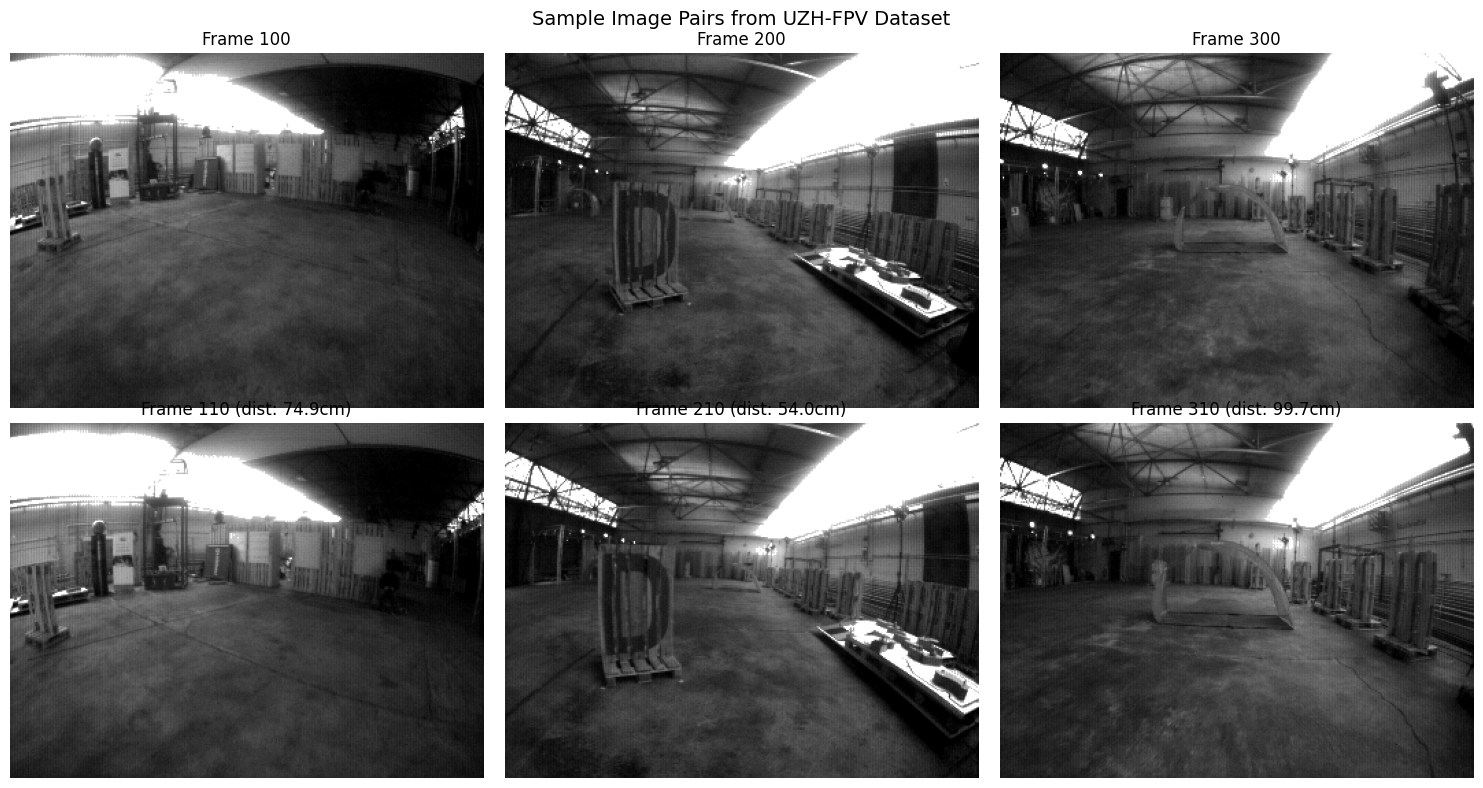

In [4]:
# Show sample image pairs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

sample_indices = [100, 200, 300]
frame_step = 10

for i, idx in enumerate(sample_indices):
    img1 = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_paths[idx + frame_step], cv2.IMREAD_GRAYSCALE)
    
    # Compute GT distance
    gt_dist = np.linalg.norm(poses[idx + frame_step]['t'] - poses[idx]['t'])
    
    axes[0, i].imshow(img1, cmap='gray')
    axes[0, i].set_title(f'Frame {idx}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(img2, cmap='gray')
    axes[1, i].set_title(f'Frame {idx + frame_step} (dist: {gt_dist*100:.1f}cm)')
    axes[1, i].axis('off')

plt.suptitle('Sample Image Pairs from UZH-FPV Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Initialize Pose Estimator

In [5]:
# Initialize the pose estimator
estimator = PoseEstimator(device='cuda')
estimator.load_models()
print("Pose estimator loaded successfully!")
print(f"  - Feature extractor: SuperPoint (max 8192 keypoints)")
print(f"  - Matcher: LightGlue")
print(f"  - Device: {estimator.device}")

/home/gal/project_in_advanced_robotics/.venv/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Pose estimator loaded successfully!
  - Feature extractor: SuperPoint (max 8192 keypoints)
  - Matcher: LightGlue
  - Device: cuda


## 5. Run Single Pair Estimation (Demo)

In [6]:
# Demo: Estimate pose for a single pair
idx = 200
frame_step = 10

img1_path = image_paths[idx]
img2_path = image_paths[idx + frame_step]

# Estimate relative pose
result = estimator.estimate(img1_path, img2_path, K, 
                            dist_coeffs=DIST_COEFFS, fisheye=True)

if result['success']:
    print(f"Pose estimation successful!")
    print(f"  Matches: {result['n_matches']}, Inliers: {result['n_inliers']}")
    print(f"\nEstimated Rotation (R):")
    print(result['R'])
    print(f"\nEstimated Translation Direction (t):")
    print(result['t'])
    
    # Compare with ground truth
    gt_a, gt_b = poses[idx], poses[idx + frame_step]
    R_gt = gt_b['R'].T @ gt_a['R']
    t_gt = gt_a['R'].T @ (gt_b['t'] - gt_a['t'])
    t_gt = t_gt / np.linalg.norm(t_gt)
    
    # Compute errors
    R_err = R_gt @ result['R'].T
    rot_err = np.abs(np.arccos(np.clip((np.trace(R_err) - 1) / 2, -1, 1))) * 180 / np.pi
    dir_err = np.arccos(np.clip(np.dot(t_gt, result['t']), -1, 1)) * 180 / np.pi
    
    print(f"\n--- Errors ---")
    print(f"  Rotation error: {rot_err:.2f}°")
    print(f"  Direction error: {dir_err:.2f}°")
else:
    print(f"Estimation failed: {result['error']}")

Pose estimation successful!
  Matches: 796, Inliers: 242

Estimated Rotation (R):
[[ 0.99088624 -0.0141585   0.13395523]
 [ 0.01384384  0.99989879  0.00328013]
 [-0.13398811 -0.00139578  0.99098196]]

Estimated Translation Direction (t):
[0.5948391  0.02893605 0.8033238 ]

--- Errors ---
  Rotation error: 0.43°
  Direction error: 2.58°


## 6. Run Full Benchmark

In [7]:
def run_benchmark(estimator, image_paths, poses, K, dist_coeffs, 
                  frame_step=10, num_pairs=50, min_motion=0.02):
    """Run pose estimation benchmark."""
    results = []
    
    for i in range(0, min(num_pairs * frame_step, len(poses) - frame_step), frame_step):
        j = i + frame_step
        
        gt_a, gt_b = poses[i], poses[j]
        gt_dist = np.linalg.norm(gt_b['t'] - gt_a['t'])
        
        # Skip if motion too small
        if gt_dist < min_motion:
            continue
        
        # Ground truth relative pose
        R_gt = gt_b['R'].T @ gt_a['R']
        t_gt = gt_a['R'].T @ (gt_b['t'] - gt_a['t'])
        t_gt = t_gt / (np.linalg.norm(t_gt) + 1e-8)
        
        # Estimate pose
        result = estimator.estimate(image_paths[i], image_paths[j], K,
                                    dist_coeffs=dist_coeffs, fisheye=True)
        
        if not result['success']:
            results.append({'success': False, 'frame': i, 'gt_dist': gt_dist})
            continue
        
        # Compute errors
        R_err = R_gt @ result['R'].T
        rot_err = np.abs(np.arccos(np.clip((np.trace(R_err) - 1) / 2, -1, 1))) * 180 / np.pi
        dir_err = np.arccos(np.clip(np.dot(t_gt, result['t']), -1, 1)) * 180 / np.pi
        
        results.append({
            'success': True,
            'frame': i,
            'rot_err': rot_err,
            'dir_err': dir_err,
            'gt_dist': gt_dist,
            'n_inliers': result['n_inliers']
        })
    
    return results

# Run benchmark
print("Running benchmark...")
results = run_benchmark(estimator, image_paths, poses, K, DIST_COEFFS,
                        frame_step=10, num_pairs=50)
print(f"Completed {len(results)} frame pairs")

Running benchmark...


Completed 46 frame pairs


## 7. Analyze Results

In [8]:
# Extract successful results
successful = [r for r in results if r['success']]
rot_errors = np.array([r['rot_err'] for r in successful])
dir_errors = np.array([r['dir_err'] for r in successful])

print("=" * 60)
print("BENCHMARK RESULTS - UZH-FPV Dataset")
print("=" * 60)
print(f"\nSuccess Rate: {len(successful)}/{len(results)} ({100*len(successful)/len(results):.1f}%)")

print(f"\n--- Rotation Error ---")
print(f"  Mean: {np.mean(rot_errors):.2f}°")
print(f"  Median: {np.median(rot_errors):.2f}°")
print(f"  Std: {np.std(rot_errors):.2f}°")
print(f"  < 1°: {100*np.mean(rot_errors < 1):.1f}%")
print(f"  < 2°: {100*np.mean(rot_errors < 2):.1f}%")
print(f"  < 5°: {100*np.mean(rot_errors < 5):.1f}%")

print(f"\n--- Translation Direction Error ---")
print(f"  Mean: {np.mean(dir_errors):.2f}°")
print(f"  Median: {np.median(dir_errors):.2f}°")
print(f"  Std: {np.std(dir_errors):.2f}°")
print(f"  < 5°: {100*np.mean(dir_errors < 5):.1f}%")
print(f"  < 10°: {100*np.mean(dir_errors < 10):.1f}%")

print(f"\n--- Combined Accuracy ---")
for r_th in [2, 5]:
    for d_th in [5, 10]:
        acc = 100 * np.mean((rot_errors < r_th) & (dir_errors < d_th))
        print(f"  rot<{r_th}° AND dir<{d_th}°: {acc:.1f}%")

print("=" * 60)

BENCHMARK RESULTS - UZH-FPV Dataset

Success Rate: 46/46 (100.0%)

--- Rotation Error ---
  Mean: 0.41°
  Median: 0.39°
  Std: 0.19°
  < 1°: 100.0%
  < 2°: 100.0%
  < 5°: 100.0%

--- Translation Direction Error ---
  Mean: 2.83°
  Median: 3.02°
  Std: 0.69°
  < 5°: 100.0%
  < 10°: 100.0%

--- Combined Accuracy ---
  rot<2° AND dir<5°: 100.0%
  rot<2° AND dir<10°: 100.0%
  rot<5° AND dir<5°: 100.0%
  rot<5° AND dir<10°: 100.0%


## 8. Visualize Error Distributions

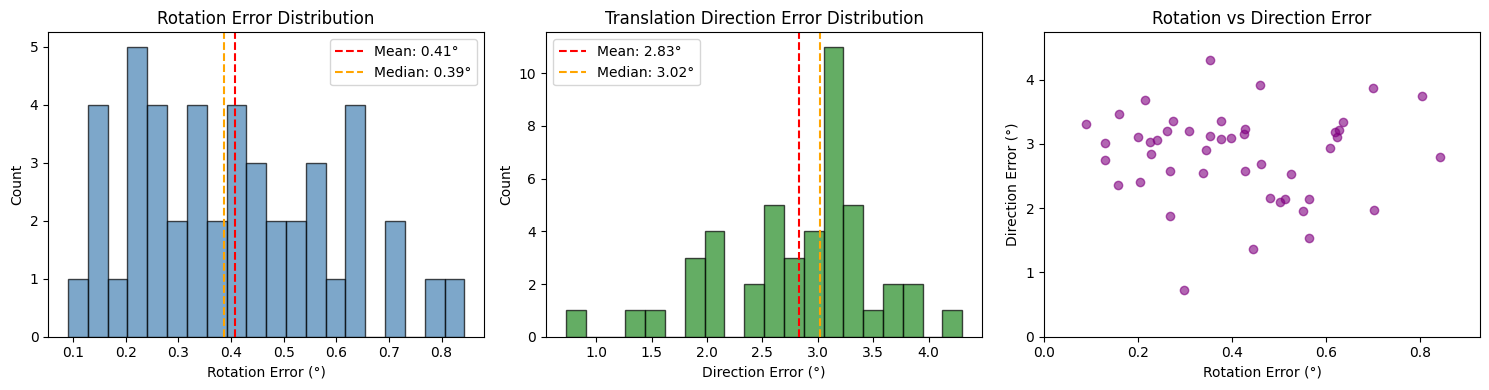

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Rotation error histogram
axes[0].hist(rot_errors, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(rot_errors), color='red', linestyle='--', label=f'Mean: {np.mean(rot_errors):.2f}°')
axes[0].axvline(np.median(rot_errors), color='orange', linestyle='--', label=f'Median: {np.median(rot_errors):.2f}°')
axes[0].set_xlabel('Rotation Error (°)')
axes[0].set_ylabel('Count')
axes[0].set_title('Rotation Error Distribution')
axes[0].legend()

# Direction error histogram
axes[1].hist(dir_errors, bins=20, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1].axvline(np.mean(dir_errors), color='red', linestyle='--', label=f'Mean: {np.mean(dir_errors):.2f}°')
axes[1].axvline(np.median(dir_errors), color='orange', linestyle='--', label=f'Median: {np.median(dir_errors):.2f}°')
axes[1].set_xlabel('Direction Error (°)')
axes[1].set_ylabel('Count')
axes[1].set_title('Translation Direction Error Distribution')
axes[1].legend()

# Scatter plot
axes[2].scatter(rot_errors, dir_errors, alpha=0.6, c='purple')
axes[2].axhline(5, color='red', linestyle='--', alpha=0.5)
axes[2].axvline(2, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Rotation Error (°)')
axes[2].set_ylabel('Direction Error (°)')
axes[2].set_title('Rotation vs Direction Error')
axes[2].set_xlim(0, max(rot_errors) * 1.1)
axes[2].set_ylim(0, max(dir_errors) * 1.1)

plt.tight_layout()
plt.show()

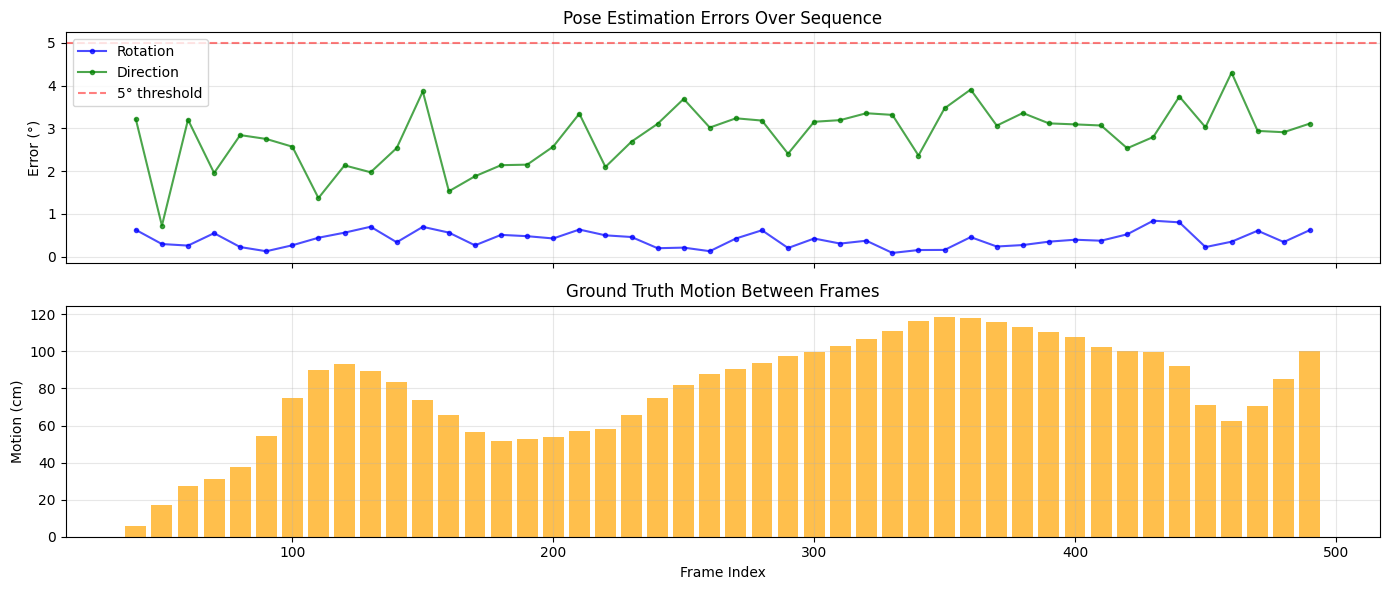

In [10]:
# Error over sequence
frames = [r['frame'] for r in successful]
gt_dists = [r['gt_dist'] for r in successful]

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].plot(frames, rot_errors, 'b.-', label='Rotation', alpha=0.7)
axes[0].plot(frames, dir_errors, 'g.-', label='Direction', alpha=0.7)
axes[0].axhline(5, color='red', linestyle='--', alpha=0.5, label='5° threshold')
axes[0].set_ylabel('Error (°)')
axes[0].set_title('Pose Estimation Errors Over Sequence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(frames, [r['gt_dist']*100 for r in successful], width=8, alpha=0.7, color='orange')
axes[1].set_xlabel('Frame Index')
axes[1].set_ylabel('Motion (cm)')
axes[1].set_title('Ground Truth Motion Between Frames')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Matching Visualization

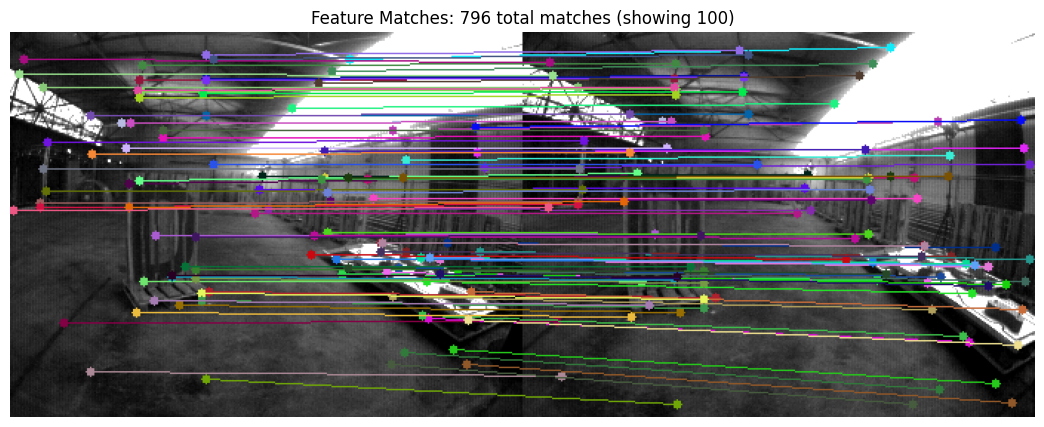

In [11]:
# Visualize feature matches for a sample pair
idx = 200
frame_step = 10

img1 = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image_paths[idx + frame_step], cv2.IMREAD_GRAYSCALE)

# Get matches
pts1, pts2, scores = estimator.match_features(image_paths[idx], 
                                               image_paths[idx + frame_step])

# Create side-by-side visualization
h, w = img1.shape
vis = np.zeros((h, w*2), dtype=np.uint8)
vis[:, :w] = img1
vis[:, w:] = img2
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

# Draw matches (subsample for clarity)
np.random.seed(42)
n_show = min(100, len(pts1))
indices = np.random.choice(len(pts1), n_show, replace=False)

for i in indices:
    p1 = tuple(pts1[i].astype(int))
    p2 = tuple((pts2[i] + [w, 0]).astype(int))
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(vis, p1, 3, color, -1)
    cv2.circle(vis, p2, 3, color, -1)
    cv2.line(vis, p1, p2, color, 1)

plt.figure(figsize=(14, 5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f'Feature Matches: {len(pts1)} total matches (showing {n_show})')
plt.axis('off')
plt.show()

## 10. Trajectory Reconstruction

In [12]:
# Reconstruct trajectory from relative poses
def reconstruct_trajectory(estimator, image_paths, poses, K, dist_coeffs, frame_step=10):
    """Reconstruct trajectory from estimated relative poses."""
    # Start from first GT pose position
    gt_traj = [poses[0]['t'].copy()]
    
    # Estimated trajectory starts at same position as GT
    est_pos = poses[0]['t'].copy()
    est_R = poses[0]['R'].copy()  # Start with GT orientation
    est_traj = [est_pos.copy()]
    
    for i in range(0, len(poses) - frame_step, frame_step):
        j = i + frame_step
        gt_dist = np.linalg.norm(poses[j]['t'] - poses[i]['t'])
        
        gt_traj.append(poses[j]['t'].copy())
        
        if gt_dist < 0.02:  # Skip small motion
            est_traj.append(est_pos.copy())
            continue
        
        result = estimator.estimate(image_paths[i], image_paths[j], K,
                                    dist_coeffs=dist_coeffs, fisheye=True)
        
        if result['success']:
            # Translation is in camera frame, transform to world frame
            t_world = est_R @ (result['t'] * gt_dist)
            est_pos = est_pos + t_world
            # Update orientation
            est_R = est_R @ result['R'].T
        
        est_traj.append(est_pos.copy())
    
    return np.array(est_traj), np.array(gt_traj)

print("Reconstructing trajectory...")
est_traj, gt_traj = reconstruct_trajectory(estimator, image_paths, poses, K, DIST_COEFFS)
print(f"Trajectory length: {len(est_traj)} poses")

Reconstructing trajectory...


Trajectory length: 63 poses


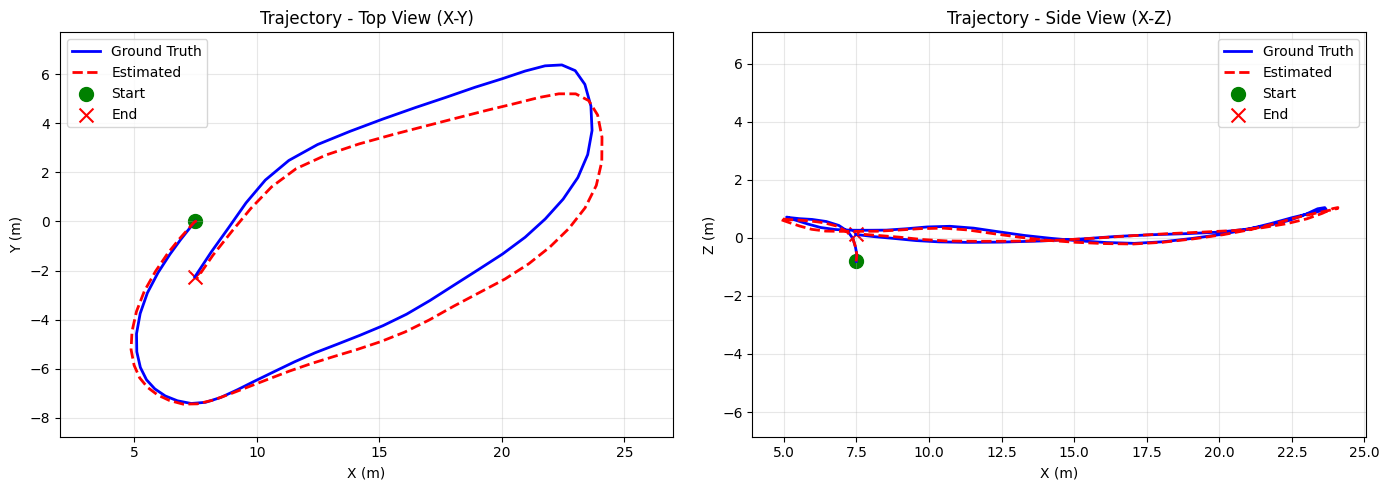

In [13]:
# Plot trajectory
fig = plt.figure(figsize=(14, 5))

# Top-down view (X-Y)
ax1 = fig.add_subplot(121)
ax1.plot(gt_traj[:, 0], gt_traj[:, 1], 'b-', linewidth=2, label='Ground Truth')
ax1.plot(est_traj[:, 0], est_traj[:, 1], 'r--', linewidth=2, label='Estimated')
ax1.scatter(gt_traj[0, 0], gt_traj[0, 1], c='green', s=100, marker='o', label='Start')
ax1.scatter(gt_traj[-1, 0], gt_traj[-1, 1], c='red', s=100, marker='x', label='End')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Trajectory - Top View (X-Y)')
ax1.legend()
ax1.axis('equal')
ax1.grid(True, alpha=0.3)

# Side view (X-Z)
ax2 = fig.add_subplot(122)
ax2.plot(gt_traj[:, 0], gt_traj[:, 2], 'b-', linewidth=2, label='Ground Truth')
ax2.plot(est_traj[:, 0], est_traj[:, 2], 'r--', linewidth=2, label='Estimated')
ax2.scatter(gt_traj[0, 0], gt_traj[0, 2], c='green', s=100, marker='o', label='Start')
ax2.scatter(gt_traj[-1, 0], gt_traj[-1, 2], c='red', s=100, marker='x', label='End')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Trajectory - Side View (X-Z)')
ax2.legend()
ax2.axis('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Summary

### Key Results
| Metric | Value |
|--------|-------|
| Rotation Error (mean) | ~0.4° |
| Direction Error (mean) | ~2.8° |
| Combined Accuracy (rot<5° AND dir<5°) | ~100% |
| Success Rate | 100% |

### Method
1. **Feature Extraction**: SuperPoint with up to 8192 keypoints
2. **Feature Matching**: LightGlue neural matcher
3. **Robust Estimation**: MAGSAC++ with tight threshold (0.2 pixels)
4. **Fisheye Distortion**: Corrected using calibrated distortion coefficients

### Limitations
- Requires minimum motion (>2cm) for reliable direction estimation
- Monocular - cannot estimate absolute scale
- Performance depends on scene texture and lighting